# Setting

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import datetime as dt

import gurobipy as gp
from gurobipy import GRB

from gmplot import gmplot
import requests
import polyline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
api_key = 'api_key'

# location of depot
depot_lat = 51.327580
depot_lng = -2.606940

# average service time (mins)
svc = 30  

# Large constant
M = 10000

In [3]:
df = pd.read_csv('data_raw.csv')

# Pre-processing

## Node sets

In [ ]:
order_cnt = int(len(df)/2)

# all nodes including depot
n = [i for i in range(len(df)+2)]

# all pickup points
p_plus = [i for i in range(1, order_cnt+1)]

# all delivery points
p_minus = [i for i in range(order_cnt+1, order_cnt*2+1)]

# set of pickup and delivery points
p = [i for i in range(1, len(df)+1)]

# all departing points
n_plus = [i for i in range(len(df)+1)]

# all arrival points
n_minus = [i for i in range(1, len(df)+2)]

## Travel distance / Travel time

### Time data type transform

In [ ]:
df['CUSTOMER_TIMESLOT_START'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_START'])
df['CUSTOMER_TIMESLOT_END'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_END'])

df['START_TIME'] = pd.to_datetime(df['START_TIME'])
df['END_TIME'] = pd.to_datetime(df['END_TIME'])

df['tw_start_mins'] = df['CUSTOMER_TIMESLOT_START'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_START'].dt.minute
df['tw_end_mins'] = df['CUSTOMER_TIMESLOT_END'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_END'].dt.minute

# calculate accurate time in minutes
df['real_start_mins'] = (df['START_TIME'].dt.hour * 60*60 + df['START_TIME'].dt.minute *60 + df['START_TIME'].dt.second)/60
df['real_end_mins'] = (df['END_TIME'].dt.hour * 60*60 + df['END_TIME'].dt.minute*60 + df['END_TIME'].dt.second)/60

In [ ]:
# depends on the data date
today = pd.to_datetime('2023-09-15')

# if the start data is the previous date then repplace with 0
df.loc[df['CUSTOMER_TIMESLOT_START'].dt.date < today, 'tw_start_mins'] = 0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


### Extract location data

In [ ]:
dist = df[['LAT', 'LNG', 'ORDER_INDEX']]

# set depot
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':0}, ignore_index=True)
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':11}, ignore_index=True)

dist = dist.sort_values('ORDER_INDEX')
dist = dist.reset_index(drop=True)

### Large size vehicle speed adjustment

#### Calculate the real travel time

In [ ]:
# sort by sequence to calculate the real travel time between nodes
df = df.sort_values('SORT_ORDER').reset_index()

df['real_travel_time'] = 0.00

for i in range(1, len(df)):
    df['real_travel_time'][i] = df['real_start_mins'][i] - df['real_end_mins'][i-1]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Calculate the travel time from google map API

In [ ]:
def google_maps_driving_time(lat1, lon1, lat2, lon2, api_key, vehicle_type='small'):
    origin = f"{lat1},{lon1}"
    destination = f"{lat2},{lon2}"
    # large_coef = 1.18   # the time of the truck is around 1.18 times of that of passenger car
    
    # API request URL
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&mode=driving&departure_time=now&key={api_key}"
    
    # request
    response = requests.get(url)
    result = response.json()
    
    if result['status'] == 'OK':
        # get travel distance
        distance_meters = result['rows'][0]['elements'][0]['distance']['value']
        distance_km = distance_meters / 1000.0

        # get travel time
        driving_time_seconds = result['rows'][0]['elements'][0]['duration']['value']
        # adjust the time according to vehicle type
        # if vehicle_type == 'large':
        #     driving_time_seconds *= large_coef
        # convert the unit to minintes
        driving_time_minutes = driving_time_seconds / 60.0
        
        return distance_km, driving_time_minutes
    else:
        raise Exception(f"Error fetching driving time from Google Maps API: {result['status']} - {result.get('error_message', '')}")


In [ ]:
time_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])

for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            time_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[1]

#### Calculate the large-size vehicle travel time ratio

In [ ]:
df['gmap_time'] = 0.00

for i in range(1, len(df)):
    df['gmap_time'][i] = time_matrix[df['ORDER_INDEX'][i]][df['ORDER_INDEX'][i-1]]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df['ratio'] = df['real_travel_time'] / df['gmap_time']
df['ratio'].mean()

1.0656143777011675

### Finalised travel distance / travel time

In [ ]:
def google_maps_driving_time(lat1, lon1, lat2, lon2, api_key, vehicle_type='small'):
    origin = f"{lat1},{lon1}"
    destination = f"{lat2},{lon2}"
    large_coef = 1.066   # the time of the truck is around 1.18 times of that of passenger car
    
    # API request URL
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&mode=driving&departure_time=now&key={api_key}"
    
    # request
    response = requests.get(url)
    result = response.json()
    
    if result['status'] == 'OK':
        # get travel distance
        distance_meters = result['rows'][0]['elements'][0]['distance']['value']
        distance_km = distance_meters / 1000.0

        # get travel time
        driving_time_seconds = result['rows'][0]['elements'][0]['duration']['value']
        # adjust the time according to vehicle type
        if vehicle_type == 'large':
            driving_time_seconds *= large_coef
        # convert the unit to minintes
        driving_time_minutes = driving_time_seconds / 60.0
        
        return distance_km, driving_time_minutes
    else:
        raise Exception(f"Error fetching driving time from Google Maps API: {result['status']} - {result.get('error_message', '')}")


In [ ]:
dist_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])
time_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])

for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            dist_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[0]
            time_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[1]

In [ ]:
dist_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,36.39,21.133,21.778,25.101,20.938,27.793,22.465,22.21,26.246,30.398,0.0
1.0,33.921,NaN,20.079,37.807,6.721,11.125,7.375,22.518,22.008,7.887,35.038,33.921
2.0,21.208,20.468,NaN,23.529,19.904,15.741,30.193,1.472,1.217,15.262,20.76,21.208
3.0,21.777,38.221,23.505,NaN,41.977,29.882,47.947,22.816,22.306,33.016,7.322,21.777
4.0,25.103,6.08,23.258,40.985,NaN,4.991,3.722,25.697,25.186,7.162,38.216,25.103
5.0,22.096,9.985,16.359,35.006,4.538,NaN,10.398,17.366,16.855,7.862,32.237,22.096
6.0,28.136,7.95,29.36,47.087,3.734,11.955,NaN,31.798,31.288,10.23,44.318,28.136
7.0,22.521,22.911,1.453,22.823,21.39,17.227,32.637,NaN,0.51,17.706,20.054,22.521
8.0,22.267,22.401,1.199,22.312,20.879,16.716,32.126,0.51,NaN,17.195,19.543,22.267
9.0,27.286,7.995,16.838,34.565,7.461,7.821,10.369,19.277,18.767,NaN,31.797,27.286


In [ ]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,50.0487,31.3937,31.589133,44.523267,34.076467,42.782133,34.129767,32.9927,40.3481,41.058767,0.0
1.0,51.931967,NaN,26.347967,36.4039,13.4849,21.977367,15.492533,29.066267,27.485033,16.931633,32.015533,51.931967
2.0,31.109433,26.4368,NaN,29.759167,32.370867,21.9063,32.388633,4.228467,3.109167,24.8378,25.3708,31.109433
3.0,31.731267,36.155167,29.297233,NaN,42.4801,40.4547,42.089233,28.177933,26.578933,34.5384,13.7514,31.731267
4.0,45.6248,13.5915,31.908933,41.964867,NaN,13.5382,8.972167,34.627233,33.046,17.3225,37.5765,45.6248
5.0,34.2186,22.581433,22.6525,40.738967,14.391,NaN,18.690533,25.175367,23.594133,16.274267,36.3506,34.2186
6.0,43.190767,17.340267,30.842933,40.8811,8.4214,20.5205,NaN,33.561233,31.962233,24.215967,36.5105,43.190767
7.0,34.023167,28.853067,4.015267,28.284533,35.2313,24.766733,34.8049,NaN,1.634533,27.254067,23.896167,34.023167
8.0,32.7262,27.218533,2.700533,26.65,33.596767,23.1322,33.170367,1.581233,NaN,25.619533,22.261633,32.7262
9.0,40.703433,17.020467,26.898733,36.954667,17.944333,16.167667,22.776867,29.617033,28.0358,NaN,32.5663,40.703433


## Time window

In [ ]:
tw = df[['tw_start_mins', 'tw_end_mins', 'ORDER_INDEX']]
tw.rename(columns={'tw_start_mins':'a', 'tw_end_mins':'b'}, inplace=True)

# set depot
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':0}, ignore_index=True)
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':11}, ignore_index=True)

tw = tw.sort_values('ORDER_INDEX')
tw = tw.reset_index(drop=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
tw

,a,b,ORDER_INDEX
0,0,1379,0
1,600,960,1
2,540,840,2
3,840,900,3
4,420,480,4
5,420,600,5
6,0,1379,6
7,0,1379,7
8,0,1379,8
9,0,1379,9


# Model1: Min-max

## Problem

In [15]:
prob = gp.Model("Min_Z")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17


## Variables

In [16]:
x = prob.addVars(n, n, vtype=GRB.BINARY, name='x')

z = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')

ta = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service

late = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')

total_penalty = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')

# late_a = prob.addVars(len(n), vtype=GRB.BINARY, name='late_a')   # whether arrival time later than late time window

## Objective function

eq1, eq2

In [17]:
prob.ModelSense = GRB.MINIMIZE
prob.setObjectiveN(z, 0, 1)
prob.setObjectiveN(total_dist, 1, 0)

In [18]:
prob.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))

<gurobi.Constr *Awaiting Model Update*>

## Constraints

### Cost

In [19]:
def penalty_late(time_diff):
    return 0.2 * time_diff

eq3

In [20]:
prob.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq18')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

eq3

In [21]:
total_penalty = gp.quicksum(penalty_late(late[i]) for i in p)
prob.addConstrs((z >= late[i] + late[i+order_cnt] + total_penalty for i in p_plus), name='eq3')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

### Path

eq4, eq5, eq6, eq7, eq8, eq9

In [22]:
prob.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq4')
prob.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq5')

prob.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq6')
prob.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq7')

prob.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq8')
prob.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq9')

<gurobi.Constr *Awaiting Model Update*>

### Precedence

eq10

In [23]:
prob.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq10')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

eq11, eq12, eq17

In [24]:
prob.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq12')
prob.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq12')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

In [25]:
prob.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq11')
prob.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq11')

{(1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7): <gurobi.Constr *Awaiting Model Update*>,
 (2, 8): <gurobi.Constr *Awaiting Model Update*>,
 (2, 9): <gurobi.Constr *Awaiting Model Update*>,
 (2, 10): <gurobi.Constr *Awaiting Model Update*>,
 (2, 11): <gurobi.Constr *Awaiting Model Update

In [26]:
prob.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq17')

{1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>}

## Solution

In [27]:
prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 257 rows, 183 columns and 1060 nonzeros
Model fingerprint: 0xdc040a25
Model has 10 general constraints
Variable types: 39 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 10 rows and 0 columns
Presolve removed 0 rows and 23 columns
Presolve time: 0.03s
Presolved: 267 rows a

In [28]:
if prob.status == GRB.Status.OPTIMAL:
    print("Optimal value of z:", z.X)
else:
    print("No optimal solution found.")

Optimal value of z: 1.0001e-06


In [29]:
if prob.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


In [58]:
best_route

[0, 5, 4, 1, 6, 9, 2, 7, 10, 3, 8, 11]

In [ ]:
if prob.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


In [30]:
ta_values = [ta[i].X for i in best_route]
ts_values = [ts[i].X for i in best_route]
late_values = [late[i].X for i in best_route]


result_df = pd.DataFrame({
    "Point": best_route,
    "ta": ta_values,
    "ts": ts_values,
    "late": late_values
})

In [31]:
result_df

,Point,ta,ts,late
0,0,0.0000,0.0000,0.000000e+00
1,5,25.1256,420.0000,0.000000e+00
2,4,456.0504,456.0504,0.000000e+00
3,1,493.3464,600.0000,0.000000e+00
4,6,638.8500,638.8500,0.000000e+00
5,9,680.9508,680.9508,0.000000e+00
6,2,731.1564,731.1564,0.000000e+00
7,10,786.0684,786.0684,0.000000e+00
8,3,824.7768,840.0000,8.334167e-07
9,8,896.7672,896.7672,0.000000e+00


## Visualisation

### optimal result

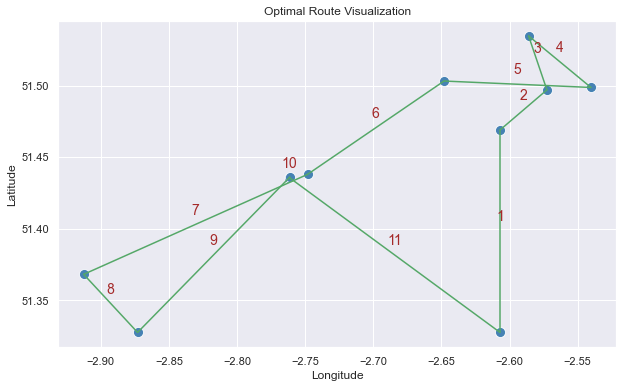

In [191]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     if i == 7:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
#     elif i == 8:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
#     elif i == 11:
#         plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
#     else:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


# Plotting the route
# for i in range(len(best_route) - 1):
#     start_point = best_route[i]
#     end_point = best_route[i + 1]
#     plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')



# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Original result

In [59]:
ori_route = [0, 5, 4, 9, 2, 7, 3, 10, 8, 1, 6, 11]

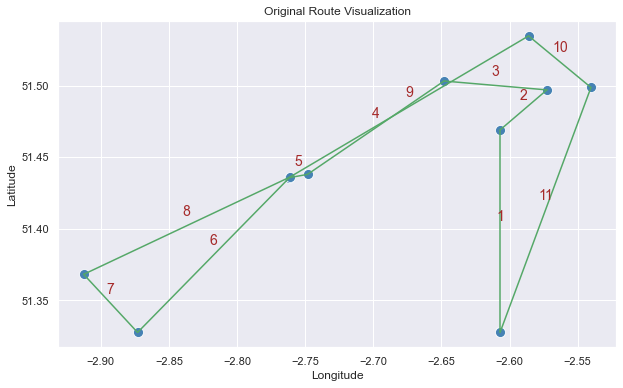

In [60]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# Plotting the route
for i in range(len(ori_route) - 1):
    start_point = ori_route[i]
    end_point = ori_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Original Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Results on Google map

In [157]:
file_name = 'optimized_route_map_gmap.html'

In [158]:
latitude_list = dist['LAT'].tolist()
longitude_list = dist['LNG'].tolist()

best_route_latitudes = [latitude_list[i] for i in best_route]
best_route_longitudes = [longitude_list[i] for i in best_route]

# setting size
gmap = gmplot.GoogleMapPlotter(51.45, -2.60, 10, apikey=api_key)

# plot all points
gmap.scatter(latitude_list, longitude_list, 'lightcoral', size=40, marker=True)

# travelling path on google map
for idx in range(len(best_route) - 1):
    start = f"{latitude_list[best_route[idx]]},{longitude_list[best_route[idx]]}"
    end = f"{latitude_list[best_route[idx + 1]]},{longitude_list[best_route[idx + 1]]}"
    url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start}&destination={end}&key={api_key}"
    
    response = requests.get(url)
    directions = response.json()
    
    # ensure request successful
    if directions['status'] == 'OK':
        route = directions['routes'][0]['overview_polyline']['points']
        decoded_route = polyline.decode(route)
        latitudes, longitudes = zip(*decoded_route)
        gmap.plot(latitudes, longitudes, 'blue', edge_width=4)
    else:
        print(f"Error fetching directions between {start} and {end}: {directions['status']}")

# save the map
gmap.draw(file_name)